### Import Modules

In [1]:
import sys
import os
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import re
import datetime
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [2]:
# Check package versions:
print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)

Python Version:  3.6.3 |Anaconda custom (64-bit)| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]
Numpy Version:  1.13.3
Pandas Version:  0.20.3


### Get Data Turnstile Data Files
Note: This section only needs to be executed once to download the data.

In [3]:
# # Define NYC MTA turnstile data URL
# url = 'http://web.mta.info/developers/turnstile.html'

In [4]:
# # Send request and verify URL
# rsp = requests.get(url)
# print(rsp.url)

In [5]:
# # Parse HTML response
# soup = bs(rsp.text, 'html.parser')

In [6]:
# # Find all anchor tags with href attribute defined
# a_tags = soup.find_all('a', href=True)

In [7]:
# file_list = []
# base_url = url.split('turnstile')[0]
# for a in a_tags:
#     tmp = re.search('data/nyct/turnstile/turnstile_\d*\.txt', a['href'])
#     if tmp is not None:
#         file_list.append(''.join([base_url, tmp.string]))        

In [8]:
# # Download txt files from NYC MTA website to local machine
# for file in file_list:
#     !wget -P ./turnstile_data/ {file}

### Compile Raw Turnstile Data
Note: This section only needs to be executed once to compile the data.

In [9]:
# # Path to local directory with files; this needs to be set by the user.
# data_path = '/home/cneiderer/Metis/turnstile_data' 
# # Initialize empty dataframe
# df = pd.DataFrame()
# # Get list of data files
# file_names = sorted(os.listdir(data_path))
# for file in file_names:
#     file_path = os.path.join(data_path, file)
#     # Load data and concatenate with existing dataframe
#     df = pd.concat([df, pd.read_csv(file_path)], axis=0)  
# # Reset index for concatenated dataframe since each dataframe has own index, 
# # which causes duplicate indices in concatenated dataframe  
# df = df.reset_index(drop=True)   
# # Save raw compiled dataframe as *.PKL for easy data retrieval
# df.to_pickle('raw_turnstile_data.pkl')

### Data Munging / Preprocessing

#### Load Data

In [10]:
# Load raw turnstile data
turn_df = pickle.load(open('raw_turnstile_data.pkl', 'rb'))# Get rid of unnecessary columns
# Load demographic data
dem_df = pd.read_csv('HH200K.csv')

#### Cleanup Columns

In [11]:
# Remove whitespace from column names and make lowercase
turn_df.columns = [x.strip().lower() for x in turn_df.columns]
dem_df.columns = [x.strip().lower() for x in dem_df.columns]

In [12]:
# Get rid of unnecessary data columns
turn_df = turn_df.drop(['c/a', 'unit', 'scp', 'linename', 'division', 'desc'], axis=1)
dem_df = dem_df.drop(['gtfs stop id'], axis=1)

In [13]:
# Rename columns to something more meaningful
turn_df.columns = ['station', 'date_str', 'time_str', 'entry_cnt', 'exit_cnt']
dem_df.columns = ['station', 'zip', 'lat', 'long', '200k_income_pct', 'bs_deg_pct', \
                  'grad_deg_pct', 'college_deg_pct', 'med_income']

#### Merge Data

In [14]:
# Make station names lowercase in both dataframes so they can be used as the merge key
turn_df.station = turn_df.station.str.lower()
dem_df.station = dem_df.station.str.lower()

In [15]:
# Merge turnstile data with demographic data via station column
merged_df = pd.merge(turn_df, dem_df, on='station')

In [16]:
# Save joined dataset
merged_df.to_pickle('merged_data.pkl')

### Count Stats

#### Load Data

In [17]:
# Load joined data
merged_df = pickle.load(open('merged_data.pkl', 'rb'))

#### Calculate Entry and Exit Counts

In [18]:
# Remove records with negative entry and exit counts. 
# Negative counts don't make sense for a cumulative counter; 
# therefore, assumed some kind of issue and removed
df = merged_df[merged_df.entry_cnt >= 0]
df = merged_df[merged_df.exit_cnt >= 0]

In [19]:
# Calculate count differences between audits; set any resulting "nan" values to "0"; add results to dataframe
df[['entries', 'exits']] = df.groupby(['station'])[['entry_cnt', 'exit_cnt']].diff().fillna(0)

In [20]:
# Remove records with negative entries and/or exits since negative counts imply a counter was modified
# for some reason.  Note: these are generally very large negative numbers
df = df[df.entries >= 0]
df = df[df.exits >= 0]
# Similarly, remove records with very large positive counts because they also imply a counter was modified
# Note: 40k was selected as a reasonable upper limit since most of the data falls in the 20k to 30k range
df = df[df.entries < 40e3]
df = df[df.exits >= 40e3]

#### Derive Station Foot-Traffic

In [21]:
# Derive station foot-traffic from entries and exits
df['foot_traffic'] = df.entries + df.exits

### Calculate Station Statistics

#### Covert Date and Time Strings

In [22]:
# Convert date and time strings to data and datetime objects
df['date'] = pd.to_datetime(df.date_str, format='%m/%d/%Y')
df['date_time'] = pd.to_datetime(df.date_str + df.time_str, format='%m/%d/%Y%H:%M:%S')

#### Find Stations with Highest Average Foot Traffic per Day

In [23]:
# Calculate the total foot traffic for each station-date combo
perday_ft_df = df.groupby(['station', 'date'])[['foot_traffic']].sum()

In [24]:
# Calculate the average foot traffic per day for each station
avg_ft_perday_df = perday_ft_df.groupby(['station']).mean()

In [25]:
avg_ft_perday_df.to_csv('avg_ft_perday.csv')

In [26]:
# Find the top 10 stations with the most foot traffic
ft_top10_df = avg_ft_perday_df.sort_values(['foot_traffic'], ascending=False).head(10)

In [27]:
ft_top10_df

,foot_traffic
station,
116 st,8.388539e+06
59 st,7.053016e+06
wall st,6.023682e+06
woodlawn,5.490847e+06
kingsbridge rd,4.016194e+06
avenue i,3.768503e+06
franklin av,2.959857e+06
28 st,2.636136e+06
71 st,2.215062e+06


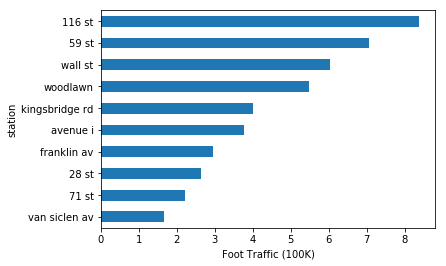

In [28]:
# Create bar chart; reverse indices of dataframe so highest foot traffic will be on top
ft_top10_rv_df = ft_top10_df.reindex(index=ft_top10_df.index[::-1])
ft_fig = ft_top10_rv_df.plot(x=ft_top10_rv_df.index, y='foot_traffic', kind='barh');
# Set axes properties
ft_fig.axes.set_xlabel('Foot Traffic (100K)')
ft_fig.axes.legend_.remove()
ft_fig.axes.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ft_fig.axes.set_xticklabels([str(int(x/1e6)) for x in ft_fig.axes.get_xticks()]);

#### Find Stations with Highest Percentage College Degrees

In [29]:
# Find the mean percentage of residents near each station with a BS degree or higher
college_df = df.groupby(['station'])[['college_deg_pct']].mean()

In [30]:
# Find the top 10 stations with highest pct of residents with college degree
college_top10_df = college_df.sort_values(['college_deg_pct'], ascending=False).head(10)

In [31]:
college_top10_df

,college_deg_pct
station,
cortlandt st,0.840753
23 st,0.834767
fulton st,0.832311
spring st,0.796875
east broadway,0.788958
28 st,0.766065
canal st,0.697019
metropolitan av,0.666911
wall st,0.663750


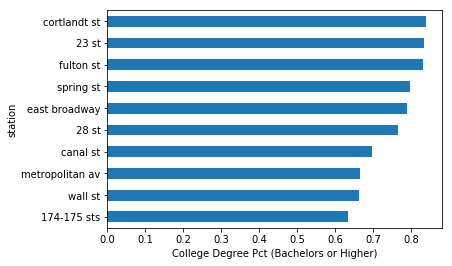

In [32]:
# Create bar chart; reverse indices of dataframe so highest degree pct will be on top
college_top10_rv_df = college_top10_df.reindex(index=college_top10_df.index[::-1])
college_fig = college_top10_rv_df.plot(x=college_top10_rv_df.index, y='college_deg_pct', kind='barh');
# Set axes properties
college_fig.axes.set_xlabel('College Degree Pct (Bachelors or Higher)')
college_fig.axes.legend_.remove()

#### Find Stations with Highest Median Household Income

In [33]:
# Find the mean median income of residents near each station
income_df = df.groupby(['station'])[['med_income']].mean()

In [34]:
# Find the top 10 stations with highest median income of residents near station
income_top10_df = income_df.sort_values(['med_income'], ascending=False).head(10)

In [35]:
income_top10_df

,med_income
station,
23 st,150949.0
28 st,130275.0
canal st,123445.0
cortlandt st,120453.0
east broadway,114398.0
fulton st,114038.0
46 st,112215.0
49 st,106499.0
wall st,80485.0


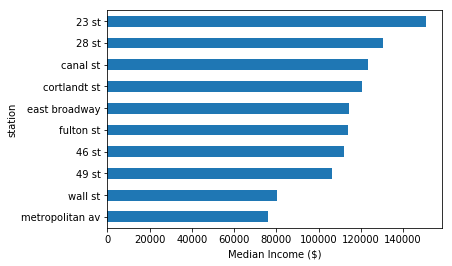

In [36]:
# Create bar chart; reverse indices of dataframe so highest degree pct will be on top
income_top10_rv_df = income_top10_df.reindex(index=income_top10_df.index[::-1])
income_fig = income_top10_rv_df.plot(x=income_top10_rv_df.index, y='med_income', kind='barh');
# Set axes properties
income_fig.axes.set_xlabel('Median Income ($)')
income_fig.axes.legend_.remove()
# income_fig.axes.set_xticklabels([str(int(x/1e3)) for x in income_fig.axes.get_xticks()]);
# income_fig.axes.set_xlabel('Median Income ($1K)')

#### Find Stations with Highest Percentage of High-Income Households

In [37]:
# Find the mean pct of high-income households near each station
k200_df = df.groupby(['station'])[['200k_income_pct']].mean()

In [38]:
# Find the top 10 stations with highest pct of high-income households
k200_top10_df = k200_df.sort_values(['200k_income_pct'], ascending=False).head(10)

In [39]:
k200_top10_df

,200k_income_pct
station,
canal st,0.380334
23 st,0.277815
46 st,0.225000
28 st,0.215648
east broadway,0.213400
fulton st,0.210422
cortlandt st,0.184576
86 st,0.125000
174-175 sts,0.113033


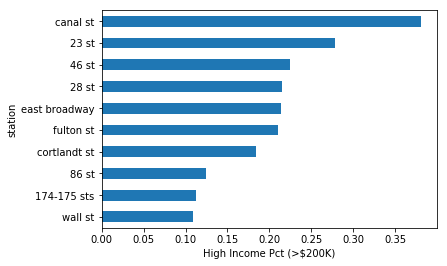

In [40]:
# Create bar chart; reverse indices of dataframe so highest degree pct will be on top
k200_top10_rv_df = k200_top10_df.reindex(index=k200_top10_df.index[::-1])
k200_fig = k200_top10_rv_df.plot(x=k200_top10_rv_df.index, y='200k_income_pct', kind='barh');
# Set axes properties
k200_fig.axes.set_xlabel('High Income Pct (>$200K)')
k200_fig.axes.legend_.remove()

### Sandbox